Using matplotlib backend: module://matplotlib_inline.backend_inline


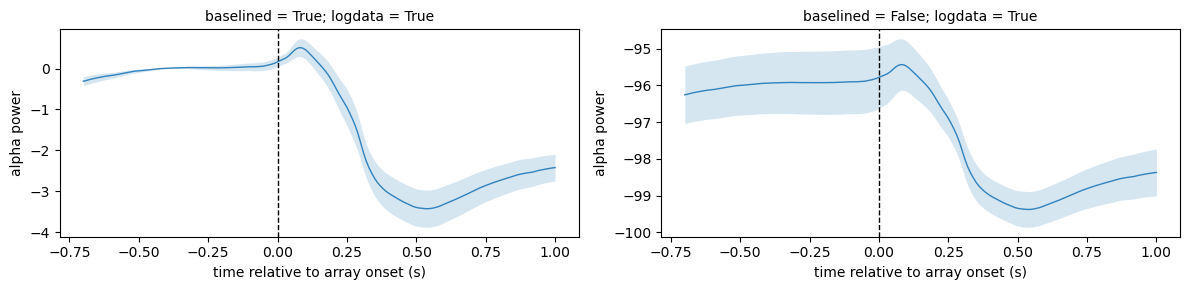

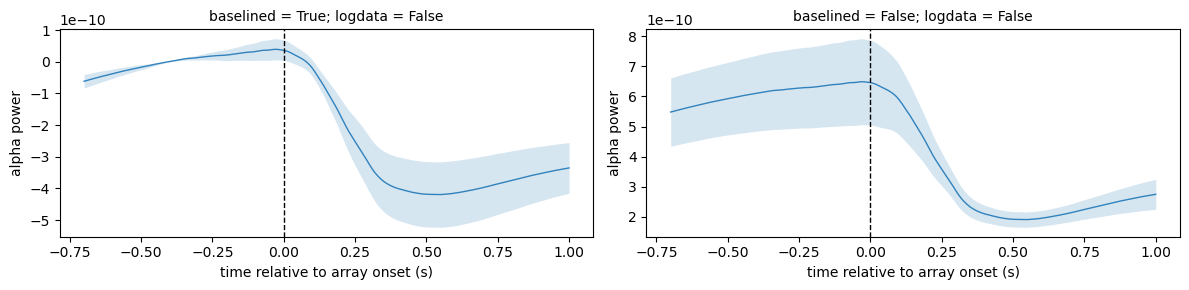

In [2]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import mne
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
from copy import deepcopy
import time
%matplotlib
#mne.viz.set_browser_backend('qt')
import progressbar
progressbar.streams.flush()

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    # sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
#1,2,3,10,19 all have only 1 session. 23 something wrong in the second session, completely unusable eeg data due to serious noise
nsubs = subs.size
# baseline_data = True 
# logdata = True

for logdata in [True, False]:
    fig = plt.figure(figsize = [12,3])
    iplot = 0
    for baseline_data in [True, False]:
        iplot += 1
        gmean = np.zeros(shape = [nsubs, 225]) * np.nan #225 time points
        gmean = np.zeros(shape = [nsubs, 171]) * np.nan
        subcount = 0
        for i in subs:
            subcount += 1
            # print(f'\n\nworking on participant {subcount}/{nsubs}')
            sub = dict(loc = loc, id = i)
            param = getSubjectInfo(sub)
            
            tfr = mne.time_frequency.read_tfrs(fname = op.join(param['path'], 'eeg', f's{i:02d}/wmConfidence_s{i:02d}_arraylocked_preproc_alpha-tfr.h5'), verbose=False)
            
            #crop data
            tfr = tfr.crop(tmin = -0.7, tmax = 1)
            # tfr = tfr.apply_baseline((-0.5, -0.3))
            
            # tfr.average().plot_joint(dB = True)
            
            vischans = [
                'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
                        'PO7', 'PO3',  'POz', 'PO4', 'PO8', 
                                'O1', 'Oz', 'O2']
            
            tfvis = tfr.copy().pick(picks=vischans)
            tfdat = tfvis._data.copy()
            
            if logdata:
                tfdat = np.multiply(10, np.log10(tfdat))
                
            if baseline_data:
                bline = [-0.5, -0.3]
                binds = np.logical_and(tfr.times>= bline[0], tfr.times <= bline[1])
                bvals = tfdat[:,:,:,binds].mean(axis=-1, keepdims=True)
                tfdat = np.subtract(tfdat, bvals) #baselines each trial, channel and frequency separately
                
            tdat = tfdat.copy().mean(2).mean(1) #average across frequencies then channels
            tdat = tdat.mean(0) #then average across trials
            gmean[subcount-1] = tdat.copy()
    
        
        gm = np.mean(gmean, axis=0)
        gsem = sp.stats.sem(gmean, axis=0, ddof=0, nan_policy='omit')
        
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        ax = fig.add_subplot(1, 2, iplot)
        ax.plot(tfr.times, gm, lw = 1, color='#3182bd')
        ax.fill_between(tfr.times, np.add(gm, gsem), np.subtract(gm, gsem), lw = 0, edgecolor=None,
                        color = '#3182bd', alpha = 0.2)
        ax.set_xlabel('time relative to array onset (s)')
        ax.set_ylabel('alpha power')
        ax.set_title(f'baselined = {baseline_data}; logdata = {logdata}', fontsize=10)
        ax.axvline(0, lw = 1, ls = 'dashed', color = 'k')
    fig.tight_layout()